In [ ]:
from SynTemp.SynUtils.utils import load_database, load_from_pickle
data = load_from_pickle('./Data/uspto/uspto_its_graph_rules_cluster.pkl.gz')

In [ ]:
from SynTemp.SynRule.rule_cluster import NaiveCluster
node_label_names = ["element", "charge"]
naive_cluster = NaiveCluster(node_label_names=node_label_names, node_label_default=["*", 0], edge_attribute="order")
its_graph_rules_cluster = naive_cluster.process_rules_clustering(data, rule_column='GraphRules')

In [ ]:
its_graph_rules_cluster[0]

In [ ]:
from SynTemp.SynUtils.utils import stratified_random_sample
import pandas as pd
sampled_data = stratified_random_sample(its_graph_rules_cluster, property_key='naive_cluster', samples_per_class=1, seed=23)
pd.DataFrame(sampled_data)['Reaction Type'].value_counts()

In [ ]:
single = [x['GraphRules'][2] for x in sampled_data if x['Reaction Type'] == 'Single Cyclic']
complex = [x['GraphRules'][2] for x in sampled_data if x['Reaction Type'] == 'Complex Cyclic']
neither = [x['GraphRules'][2] for x in sampled_data if x['Reaction Type'] == 'None']
acyclic = [x['GraphRules'][2] for x in sampled_data if x['Reaction Type'] == 'Acyclic']

In [ ]:
from SynTemp.SynVis.chemical_graph_vis import ChemicalGraphVisualizer
vis = ChemicalGraphVisualizer()
vis.graph_vis(complex[4], show_node_labels=True)

In [ ]:
from SynTemp.SynRule.rule_decompose import GraphRuleDecompose

In [ ]:
from copy import deepcopy
complex_graph = complex[11]
# Add nodes and edges to complex_graph with the required attributes

single_cyclic_graphs = deepcopy(single)
# Define your single cyclic graphs by adding nodes and edges with the required attributes

# Call the function
explained_graphs = GraphRuleDecompose.bfs_remove_isomorphic_subgraphs(complex_graph, single_cyclic_graphs)

if explained_graphs is not None:
    print("List of single cyclic graphs that explain the complex graph:", explained_graphs)
    GraphRuleDecompose.visualize_with_common_subgraphs(complex_graph, explained_graphs)
else:
    print("Some parts of the complex graph could not be explained by any of the single cyclic graphs.")

In [ ]:
import pandas as pd 

df = pd.read_csv('./Data/golden/golden_dataset.csv')
df.head(2)

from SynTemp.SynUtils.utils import load_database
data = load_database('./Data/golden/golden_aam_reactions.json.gz')
for key, value in enumerate(data):
    data[key]['ground_truth'] = df.iloc[key,0]

In [ ]:
from SynTemp.SynUtils.utils import load_database
data = load_database('./Data/golden/golden_aam_reactions.json.gz')
for key, value in enumerate(data):
    data[key]['ground_truth'] = df.iloc[key,0]

In [ ]:
pd.DataFrame(data).info()

In [ ]:
from SynTemp.SynAAM.aam_validator import AMMValidator 
for key, value in enumerate(data):
    try:
        AMMValidator.smiles_check(data[key]['ground_truth'], data[key]['rdt'])
    except:
        print(key)

In [ ]:
data[366]['rdt']

In [ ]:
from SynTemp.SynAAM.aam_validator import AMMValidator  
results = AMMValidator.validate_smiles(data=data, ground_truth_col='ground_truth', 
                                       mapped_cols=['rxn_mapper', 'graphormer', 'local_mapper', 'rdt'], 
                                       check_method='RC', 
                                       ignore_aromaticity=False, n_jobs=4, verbose=0)

In [ ]:
pd.DataFrame(results)[['mapper', 'accuracy']]

In [ ]:
from SynTemp.SynAAM.aam_validator import AMMValidator  
results = AMMValidator.validate_smiles(data=data, ground_truth_col='Ground turth', 
                                       mapped_cols=['RXNMapper', 'GraphMapper', 'LocalMapper'], 
                                       check_method='RC', 
                                       ignore_aromaticity=False, n_jobs=4, verbose=0)

In [ ]:
pd.DataFrame(results)[['mapper', 'accuracy']]

In [ ]:
pd.DataFrame(results)[['mapper', 'accuracy']]

In [ ]:
from SynTemp.SynUtils.utils import load_database
recon = load_database('./Data/Recon3D/Recon3D_aam_reactions.json.gz')

from SynTemp.SynAAM.aam_validator import AMMValidator  
results, _ = AMMValidator.validate_smiles(data=recon, ground_truth_col='ground_truth', 
                                       mapped_cols=['rxn_mapper', 'graphormer', 'local_mapper', 'rdt'], 
                                       check_method='RC', 
                                       ignore_aromaticity=False, n_jobs=4, verbose=0, ensemble=True)

In [ ]:
pd.DataFrame(recon).to_csv('./Data/Recon3D/Recon3D_aam_reactions.csv')

In [ ]:
import pandas as pd
pd.DataFrame(results)[['mapper', 'accuracy', 'success_rate']]

In [ ]:
import pandas as pd

In [ ]:
ecoli = pd.read_csv('./Data/ecoli/ecoli.smiles', header=None)
ecoli.rename({0:'ground_truth'}, axis=1, inplace=True)
ecoli['R-id'] = range(1, len(ecoli) + 1)

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions
ok = []
bug = []
for key, value in enumerate(ecoli['ground_truth']):
    try:
        rdChemReactions.ReactionFromSmarts(value)
        ok.append(key)
    except:
        bug.append(key)

In [ ]:
a,b,c =ecoli['ground_truth'][bug[0]].split('>>')

In [ ]:
print(ecoli.iloc[bug,:]['ground_truth'])

In [ ]:
ecoli = ecoli.iloc[ok, :]
ecoli.reset_index(drop=True, inplace=True)
#ecoli = ecoli.to_dict('records')

In [ ]:
from SynTemp.SynUtils.utils import save_database
save_database(ecoli, './Data/ecoli/ecoli_reactions.json.gz')

In [ ]:
Chem.MolFromSmiles(ecoli.loc[189, 'reactions'])

In [ ]:
bug

In [ ]:

rxn = rdChemReactions.ReactionFromSmarts('[C:1](=[O:2])O.[N:3]>>[C:1](=[O:2])[N:3]')
reacts = (Chem.MolFromSmiles('C(=O)O'),Chem.MolFromSmiles('CNC'))
products = rxn.RunReactants(reacts)

In [ ]:
from SynTemp.SynUtils.utils import load_database
recon = load_database('./Data/Recon3D/Recon3D_aam_reactions.json.gz')

from SynTemp.SynAAM.aam_validator import AMMValidator  
results, _ = AMMValidator.validate_smiles(data=recon, ground_truth_col='ground_truth', 
                                       mapped_cols=['rxn_mapper', 'graphormer', 'local_mapper'], 
                                       check_method='RC', 
                                       ignore_aromaticity=False, n_jobs=4, verbose=0, ensemble=True)

import pandas as pd
pd.DataFrame(results)[['mapper', 'accuracy', 'success_rate']]

In [ ]:
recon[0]

In [ ]:
from SynTemp.SynUtils.utils import load_database
recon = load_database('./Data/ecoli/ecoli_aam_reactions.json.gz')

from SynTemp.SynAAM.aam_validator import AMMValidator  
results, _ = AMMValidator.validate_smiles(data=recon, ground_truth_col='ground_truth', 
                                       mapped_cols=['rxn_mapper', 'graphormer', 'local_mapper', 'rdt', 'ground_truth'], 
                                       check_method='RC', 
                                       ignore_aromaticity=False, n_jobs=4, verbose=0, ensemble=False)

import pandas as pd
pd.DataFrame(results)[['mapper', 'accuracy', 'success_rate']]

In [ ]:
test = pd.DataFrame(recon).drop(['reactions'], axis =1)
test['local_mapper_result'] = pd.DataFrame(results).loc[2, 'results']
test['rxn_mapper_result'] = pd.DataFrame(results).loc[0, 'results']
test['graphormer_result'] = pd.DataFrame(results).loc[1, 'results']
test['rdt_result'] = pd.DataFrame(results).loc[3, 'results']

In [ ]:
test.to_csv('./Data/ecoli/ecoli_aam_reactions.csv')

In [ ]:
pd.DataFrame(results)

In [ ]:
pd.DataFrame(results).loc[2, 'results']

In [ ]:
test_2 = test[['local_mapper_result', 'rxn_mapper_result', 'graphormer_result', 'rdt_result']]

In [ ]:
def ensemble_results(df, threshold):
    # Calculate the sum of True values in each row
    true_counts = df.sum(axis=1)
    # Apply the threshold to determine the final result
    final_results = true_counts >= threshold
    return final_results

test_3 = ensemble_results(test_2, 2)

In [ ]:
test_3.sum()/273

In [ ]:
uspto_sample = pd.read_csv('./Data/aam_benchmark/USPTO_sampled.csv')

In [ ]:
uspto_sample['LocalMapper_correct'].sum()

In [ ]:
uspto_sample

# Bug

In [ ]:
import pandas as pd 

df = pd.read_csv('./Data/aam_benchmark/Golden_mappings.csv')
df = pd.read_csv('./Data/aam_benchmark/benchmark.csv')
df = pd.read_csv('./Data/aam_benchmark/NatComm_mappings.csv')
df = pd.read_csv('./Data/aam_benchmark/USPTO_sampled.csv')
df = pd.read_csv('./Data/ecoli/ecoli_aam_reactions.csv')
#df = pd.read_csv('./Data/Recon3D/Recon3D_aam_reactions.csv')
df.head(1)

In [ ]:
from SynTemp.SynAAM.aam_validator import AMMValidator  
results, _ = AMMValidator.validate_smiles(data=df, ground_truth_col='ground_truth', 
                                       mapped_cols=['ground_truth'], 
                                       check_method='RC', 
                                       ignore_aromaticity=False, n_jobs=4, verbose=0, ensemble=False)

import pandas as pd
pd.DataFrame(results)[['mapper', 'accuracy', 'success_rate']]

In [ ]:
test_0 = df[['ground_truth', 'R-id']]
test_0['results'] = results[0]['results']

In [ ]:
test_0_bug = test_0.loc[test_0['results']==False, :]

In [ ]:
rsmi = test_0_bug['ground_truth'][74]

In [ ]:
from SynTemp.SynITS.its_construction import ITSConstruction
from SynTemp.SynITS.its_extraction import ITSExtraction
reactants, products = rsmi.split('>>')
G, H = ITSExtraction.graph_from_smiles(reactants), ITSExtraction.graph_from_smiles(products)

In [ ]:
rsmi

In [ ]:
reactants

In [ ]:
from rdkit import Chem
Chem.MolFromSmiles(reactants)

In [ ]:
from SynTemp.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()

In [ ]:
vis.visualize_reaction(test_0_bug.iloc[0]['ground_truth'])

In [ ]:
test_0_bug.iloc[0]['ground_truth']

In [ ]:
import pandas as pd


df = pd.read_csv('./Data/USPTO_50K/USPTO_50K.csv')
df.drop_duplicates(subset=['reactions'], inplace=True)
df['R-id'] = ['USPTO-' + str(i) for i in range(len(df))]
df.head(2)

# MOD

In [ ]:
from SynTemp.SynRule.rule_executor import RuleExecutor
test = RuleExecutor.reaction_prediction(input_smiles=['C=C1C(=C)C2OC1C1=C2CC(C(C)=O)CC1'],
                                        rule_file_path='./Data/uspto/Rule/USPTO_50K_31.gml',
                                        prediction_type='backward', repeat_times=1, print_results=False)

test

In [ ]:
from SynTemp.SynRule.rule_executor import RuleExecutor
from SynTemp.SynUtils.utils import load_database
database = load_database('./test_database.json.gz')
test = RuleExecutor.reaction_database_prediction(database=database[:],  rule_file_path='./Data/uspto/Rule/',
                                         original_rsmi_col='reactions', prediction_type = 'backward', repeat_times=1)


In [ ]:
from SynTemp.SynRule.rule_benchmark import RuleBenchmark
from SynTemp.SynUtils.utils import load_database
database = load_database('./test_database.json.gz')
fw, bw = RuleBenchmark.reproduce_reactions(database=database[:],  id_col='R-id', rule_file_path='./Data/uspto/Rule',
                                         original_rsmi_col='reactions', repeat_times=1)

In [ ]:
import pandas as pd
pd.DataFrame(bw).info()

# Ranking

In [ ]:
from SynTemp.SynUtils.utils import load_database
from SynTemp.SynRule.rule_benchmark import RuleBenchmark
database = load_database('./test_database.json.gz')
fw, bw = RuleBenchmark.reproduce_reactions(database=database[:],  id_col='R-id', rule_file_path='./Data/uspto/Rule',
                                         original_rsmi_col='reactions', repeat_times=1, prior=True)

In [ ]:
import pandas as pd
pd.DataFrame(bw).info()

In [ ]:
from SynTemp.SynRule.similarity_ranking import SimilarityRanking


processed_dicts = SimilarityRanking.process_list_of_dicts(fw, 'unrank', ['FCFP6'])
print("Top 5 accuracy:", RuleBenchmark.TopKAccuracy(processed_dicts, 'reactions','rank', 2, ignore_stero=True))

In [ ]:
processed_dicts = SimilarityRanking.process_list_of_dicts(fw, 'unrank', ['RDK7'])
print("Top 5 accuracy:", RuleBenchmark.TopKAccuracy(processed_dicts, 'reactions','rank', 5, ignore_stero=True))

## Visualize

In [ ]:
from SynTemp.SynUtils.utils import load_database
data = load_database('./Data/uspto_sample/uspto_sample_aam_reactions.json.gz')

In [ ]:
from SynTemp.SynVis.chemical_reaction_visualizer import ChemicalReactionVisualizer
vis = ChemicalReactionVisualizer()
vis.visualize_and_compare_reactions(data[0], num_cols=3)

In [ ]:
from SynTemp.SynVis.its_visualizer import ITSVisualizer
from IPython.display import Image
its_vis = ITSVisualizer(data[0]['rxn_mapper'])
display(Image(its_vis.draw_product_with_modified_bonds()))

In [ ]:
import pandas as pd

df = pd.read_csv('./Data/USPTO_50K/USPTO_50K.csv')

In [ ]:
df['reactions'][0]

In [ ]:
from SynTemp.SynVis.chemical_reaction_visualizer import ChemicalReactionVisualizer
vis = ChemicalReactionVisualizer()
vis.visualize_reaction(df['reactions'][2], show_atom_map=False)

In [ ]:
df['reactions'][2]

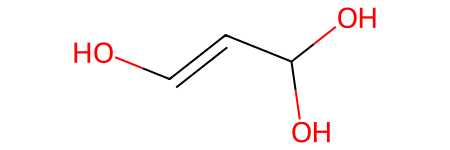

In [145]:
Chem.MolFromSmiles('C(O)(O)C=CO')

In [203]:
from fgutils import FGQuery
smiles = "C(O)(O)C=CO" # acetylsalicylic acid
query = FGQuery(use_smiles=True) # use_smiles requires rdkit to be installed
query.get(smiles)

[('hemiketal', [0, 1, 2]), ('enol', [3, 4, 5])]

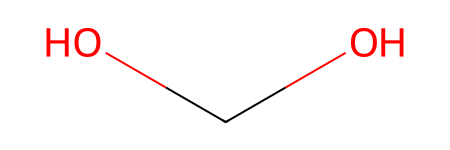

In [165]:
Chem.MolFromSmiles('C(O)(O)')

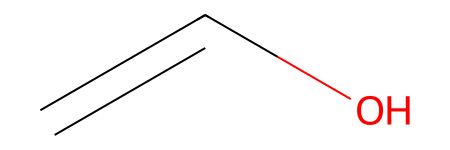

In [176]:
Chem.MolFromSmiles('C=CO')

In [3]:
import pandas as pd

df = pd.read_csv('./Data/uspto_sample/uspto_sample.csv')
df['GroundTruth'] = df['GraphMapper']
df.loc[df['GraphMapper_correct']==False, 'GroundTruth'] = df.loc[df['GraphMapper_correct']==False, 'LocalMapper']
df = df[['sampled_id', 'RXNMapper', 'GraphMapper', 'LocalMapper', 'GroundTruth']]


In [4]:
df.to_csv('uspto_3k')

,sampled_id,RXNMapper,GraphMapper,LocalMapper,GroundTruth
0,44925,CCN(CC)CC.CCOCC.CS(C)=O.ClCCl.O=S(=O)=O.[OH:1]...,[CH2:2]([CH3:1])[N:3]([CH2:4][CH3:5])[CH2:6][C...,CCN(CC)CC.CCOCC.CS(C)=O.ClCCl.O=S(=O)=O.[O:1]=...,CCN(CC)CC.CCOCC.CS(C)=O.ClCCl.O=S(=O)=O.[O:1]=...
1,11629,CC#N.O=C(OCc1ccccc1)[N:5]1[CH2:4][C@H:3]([CH2:...,[CH3:1][C:2]#[N:3].[cH:15]1[cH:14][c:13]([cH:1...,CC#N.O=C(OCc1ccccc1)[N:1]1[CH2:2][C@H:3]([CH2:...,CC#N.O=C(OCc1ccccc1)[N:1]1[CH2:2][C@H:3]([CH2:...
2,11437,CC(C)=O.COC[O:20][c:19]1[c:16]([O:17][CH3:18])...,[CH3:1][C:2]([CH3:3])=[O:4].[ClH:29].[OH2:30]....,CC(C)=O.COC[O:1][c:2]1[c:3]([O:4][CH3:5])[cH:6...,CC(C)=O.COC[O:1][c:2]1[c:3]([O:4][CH3:5])[cH:6...
3,36797,CC(C)(C)OC(=O)[NH:16][CH2:15][c:14]1[cH:13][cH...,[CH3:21][C:20]([CH3:22])([CH3:23])[O:19][C:17]...,CC(C)(C)OC(=O)[NH:1][CH2:2][c:3]1[cH:4][cH:5][...,CC(C)(C)OC(=O)[NH:1][CH2:2][c:3]1[cH:4][cH:5][...
4,25803,[CH3:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][c:7]([C...,[BH4-:17].[C:2](=[O:3])([c:4]1[cH:10][n:9][c:7...,CO.O=C([O-])O.[BH4-].[CH3:1][C:2](=[O:3])[c:4]...,CO.O=C([O-])O.[BH4-].[CH3:1][C:2](=[O:3])[c:4]...
...,...,...,...,...,...
2995,29081,[CH3:1][CH2:2][CH2:3][c:4]1[n:5][n:6][c:7]([NH...,[C:17](=[O:18])=[N:16][CH3:15].[CH3:10][N:11](...,CN(C)C=O.[CH3:1][N:2]=[C:3]=[O:4].[CH3:12][CH2...,CN(C)C=O.[CH3:1][N:2]=[C:3]=[O:4].[CH3:12][CH2...
2996,20782,O[CH:9]([CH:8]1[CH:6]([C:4]([O:3][CH2:2][CH3:1...,[C:18](#[N:19])[c:17]1[c:20]2[c:14]([nH:15][cH...,CC[SiH](CC)CC.ClCCl.O=C(O)C(F)(F)F.O[CH:1]([CH...,CC[SiH](CC)CC.ClCCl.O=C(O)C(F)(F)F.O[CH:1]([CH...
2997,11479,CCN(C(C)C)C(C)C.ClCCl.[N:1]#[C:2][CH2:3][c:4]1...,[CH3:5][CH:4]([CH3:6])[N:3]([CH:7]([CH3:8])[CH...,CCN(C(C)C)C(C)C.ClCCl.Cl[C:1](=[O:2])[c:3]1[cH...,CCN(C(C)C)C(C)C.ClCCl.Cl[C:1](=[O:2])[c:3]1[cH...
2998,15851,[CH2:1]=[CH:2][CH2:3][N:4]([CH3:5])[CH2:6][C@@...,[C@H:7]([CH2:6][N:4]([CH2:3][CH:2]=[CH2:1])[CH...,F[c:1]1[cH:11][cH:12][cH:13][c:14]2[n:15][cH:1...,F[c:1]1[cH:11][cH:12][cH:13][c:14]2[n:15][cH:1...


In [5]:
df = pd.read_csv('./Data/uspto_sample/uspto_sample.csv')

In [7]:
df['GraphMapper_correct'].sum()

2853

In [14]:
df

,sampled_id,RXNMapper,GraphMapper,LocalMapper
0,44925,CCN(CC)CC.CCOCC.CS(C)=O.ClCCl.O=S(=O)=O.[OH:1]...,[CH2:2]([CH3:1])[N:3]([CH2:4][CH3:5])[CH2:6][C...,CCN(CC)CC.CCOCC.CS(C)=O.ClCCl.O=S(=O)=O.[O:1]=...
1,11629,CC#N.O=C(OCc1ccccc1)[N:5]1[CH2:4][C@H:3]([CH2:...,[CH3:1][C:2]#[N:3].[cH:15]1[cH:14][c:13]([cH:1...,CC#N.O=C(OCc1ccccc1)[N:1]1[CH2:2][C@H:3]([CH2:...
2,11437,CC(C)=O.COC[O:20][c:19]1[c:16]([O:17][CH3:18])...,[CH3:1][C:2]([CH3:3])=[O:4].[ClH:29].[OH2:30]....,CC(C)=O.COC[O:1][c:2]1[c:3]([O:4][CH3:5])[cH:6...
3,36797,CC(C)(C)OC(=O)[NH:16][CH2:15][c:14]1[cH:13][cH...,[CH3:21][C:20]([CH3:22])([CH3:23])[O:19][C:17]...,CC(C)(C)OC(=O)[NH:1][CH2:2][c:3]1[cH:4][cH:5][...
4,25803,[CH3:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][c:7]([C...,[BH4-:17].[C:2](=[O:3])([c:4]1[cH:10][n:9][c:7...,CO.O=C([O-])O.[BH4-].[CH3:1][C:2](=[O:3])[c:4]...
...,...,...,...,...
2995,29081,[CH3:1][CH2:2][CH2:3][c:4]1[n:5][n:6][c:7]([NH...,[C:17](=[O:18])=[N:16][CH3:15].[CH3:10][N:11](...,CN(C)C=O.[CH3:1][N:2]=[C:3]=[O:4].[CH3:12][CH2...
2996,20782,O[CH:9]([CH:8]1[CH:6]([C:4]([O:3][CH2:2][CH3:1...,[C:18](#[N:19])[c:17]1[c:20]2[c:14]([nH:15][cH...,CC[SiH](CC)CC.ClCCl.O=C(O)C(F)(F)F.O[CH:1]([CH...
2997,11479,CCN(C(C)C)C(C)C.ClCCl.[N:1]#[C:2][CH2:3][c:4]1...,[CH3:5][CH:4]([CH3:6])[N:3]([CH:7]([CH3:8])[CH...,CCN(C(C)C)C(C)C.ClCCl.Cl[C:1](=[O:2])[c:3]1[cH...
2998,15851,[CH2:1]=[CH:2][CH2:3][N:4]([CH3:5])[CH2:6][C@@...,[C@H:7]([CH2:6][N:4]([CH2:3][CH:2]=[CH2:1])[CH...,F[c:1]1[cH:11][cH:12][cH:13][c:14]2[n:15][cH:1...
